In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from torch.nn.utils import clip_grad_norm_

import imageio
import os
import glob
from plots import *

import tensorflow_docs.vis.embed as embed
from Parameters import *
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
%matplotlib inline 
sns.set(color_codes=True)


In [3]:
from Parameters import *
from functions import *
from torch.utils.data import DataLoader, TensorDataset

prob = torch.tensor([P_EDU] * J)
ep_t_e = e((J, T_LR-AGE_0))
theta_t_e = torch.cumsum(ep_t_e, dim=-1) + THETA_0
edu_e = torch.bernoulli(prob)
u_t_e = mu(edu_e.unsqueeze(1), torch.arange(1, T_LR-AGE_0 + 1))
w_t_e = wage(u_t_e, theta_t_e)
dataset_eval = TensorDataset(theta_t_e, w_t_e, edu_e)
dataloader_eval = DataLoader(dataset_eval, batch_size=100000)

In [4]:
from model import Model
device = 'cuda'
# base_dir  = f'Saved_stuff/trainig_images_200_01_x(t)_change_hour_choices'
model = torch.load(f'/home/zdelbari/zdelbari/HDPS/HDPS/Experiments/multiple_r--steep_pr_a100_trueReg/base_model_with_regu_wb_each10_10HiddenUnits_seed92_phi0.0006/10000_batch_size/PSI0.04/lambda0.01/AdamW_lr:0.001/model/epoch100/model.pt')
# model = torch.load(f'/home/zdelbari/HDPS/Saved_stuff/multipleBlockR--pr--weighted_sum_H/base_model_with_regu_wb_each10_10HiddenUnits_seed92/10000_batch_size/PSI0.04/lambda0.01/AdamW_lr:0.001/model.pt')
# model_steep_phi0 = torch.load(f'/home/zdelbari/HDPS/multipleBlockR--pr--weighted_sum_H--steeper_p--debuged--alpha__1000/base_model_with_regu_wb_each10_10HiddenUnits_seed92_phi0.0/10000_batch_size/PSI0.04/lambda0.01/AdamW_lr:0.001/model/model_epoch500.pt', map_location=device)

# model_steep = torch.load(f'/home/zdelbari/HDPS/multipleBlockR--pr--weighted_sum_H--steeper_p--debuged--alpha__minse1000/base_model_with_regu_wb_each10_10HiddenUnits_seed92/10000_batch_size/PSI0.04/lambda0.01/AdamW_lr:0.001/model/model_epoch700.pt')



# /home/zdelbari/zdelbari/HDPS/Saved_stuff/vanila_model/base_model_with_regu_wb_each10_10HiddenUnits_seed982/1000_batch_size/PSI0.04/lambda0.1/AdamW_lr:0.1/model_epoch990.pt

model.to(device)
# model_steep_phi0.to(device)
# model_steep.to(device)




Model(
  (work_block): ModuleDict(
    (year_22): WorkYearBlock(
      (bn_input): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation_function): GELU(approximate='none')
      (general_layer_1): Linear(in_features=3, out_features=10, bias=True)
      (general_layer_2): Linear(in_features=10, out_features=10, bias=True)
      (task_a_w): TaskBlock(
        (task_layer): Linear(in_features=10, out_features=10, bias=True)
        (year_layer): Linear(in_features=10, out_features=1, bias=True)
        (activation_function): GELU(approximate='none')
      )
      (task_h): TaskBlock(
        (task_layer): Linear(in_features=10, out_features=10, bias=True)
        (year_layer): Linear(in_features=10, out_features=4, bias=True)
        (activation_function): GELU(approximate='none')
      )
      (a_activation): Sigmoid()
    )
    (year_23): WorkYearBlock(
      (bn_input): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [5]:
from utils import *
def do_eval_save(model, dataloader, device):
  
    
    
    all_w = []
    all_a = []
    all_h = []
    all_y = []
    all_c = []
    all_p = []
    all_t = []
    all_edu = []
    all_theta = []
    model.eval()

    for batch_idx, batch in enumerate(dataloader):
        with torch.no_grad():

            theta_t, w_t, edu = batch
            
            w_t = w_t.to(device)
            len_batch = len(batch[0])
            a_1 = torch.tensor([A_1]* len_batch)
            
            a_t, c_t, all_c_ER, pr, all_pr, h_t, y_t  = model(theta_t.to(device), edu.to(device), a_1.to(device),w_t)
        

            all_w.extend(w_t.cpu())
            all_edu.extend(edu.cpu())
            
            all_theta.extend(theta_t.cpu())
            
            all_a.extend(a_t.cpu())
            all_h.extend(h_t.cpu())
            all_y.extend(y_t.cpu())
            all_c.extend(c_t.cpu())
            all_p.extend(pr.cpu())
            # all_t.extend(r_t.cpu())
            
            
    all_w = torch.stack(all_w)
    all_a = torch.stack(all_a)
    all_h = torch.stack(all_h)
    all_y = torch.stack(all_y)  
    all_c = torch.stack(all_c)
    all_theta = torch.stack(all_theta)
    all_p =  torch.stack(all_p)
    all_edu = torch.stack(all_edu)
    return   all_a, all_h, all_w, all_c, all_y, all_p, all_edu, all_theta
    
    # utility_retirement(all_c, all_h, epoch, s_writer,args, mode='eval')
    # draw_all_plots(base_dir, all_a, all_h, all_w, all_theta, all_c, all_y)

In [6]:
all_a, all_h, all_w, all_c, all_y, all_p, all_edu, all_theta = do_eval_save(model, dataloader_eval, device)
# all_a_s, all_h_s, all_w_s, all_c_s, all_y_s, all_p_s, all_edu_s = do_eval_save(model_steep, dataloader_eval, device)
# all_a_s_phi0, all_h_s_phi0, all_w_s_phi0, all_c_s_phi0, all_y_s_phi0, all_p_s_phi0, all_edu_s_phi0, all_theta_s_phi0 = do_eval_save(model_steep_phi0, dataloader_eval, device)


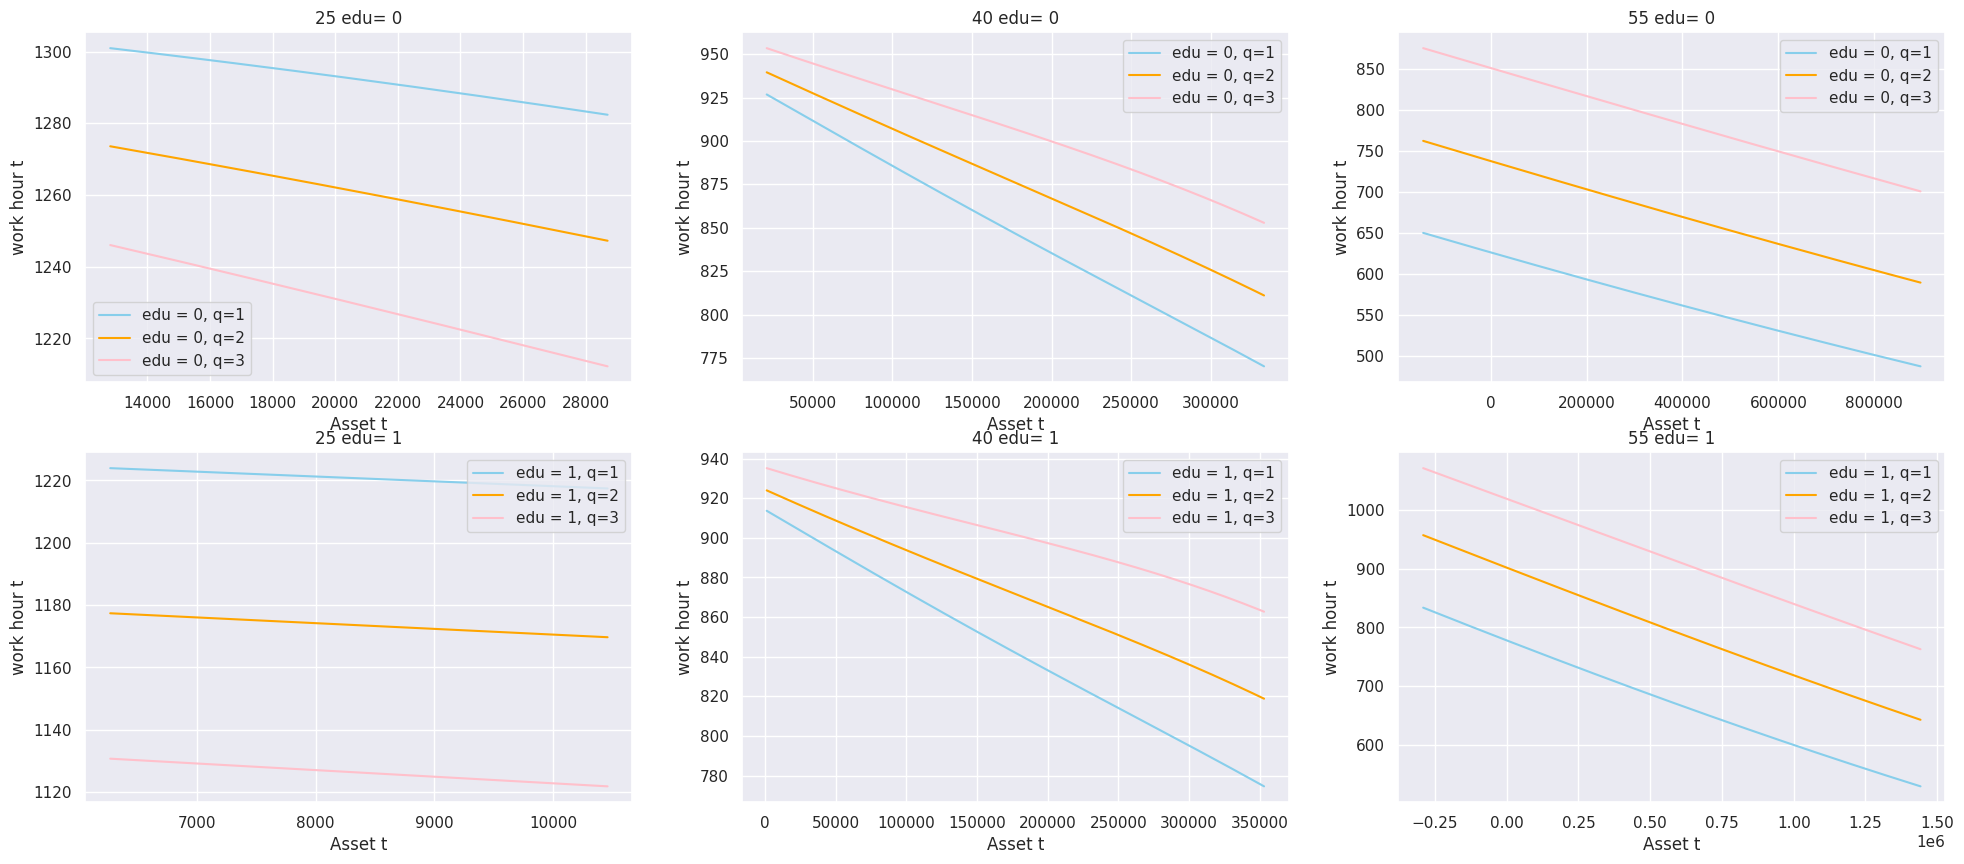

In [17]:


policy_function_plot_asset(model, all_edu, 'workhour', all_a, all_w)

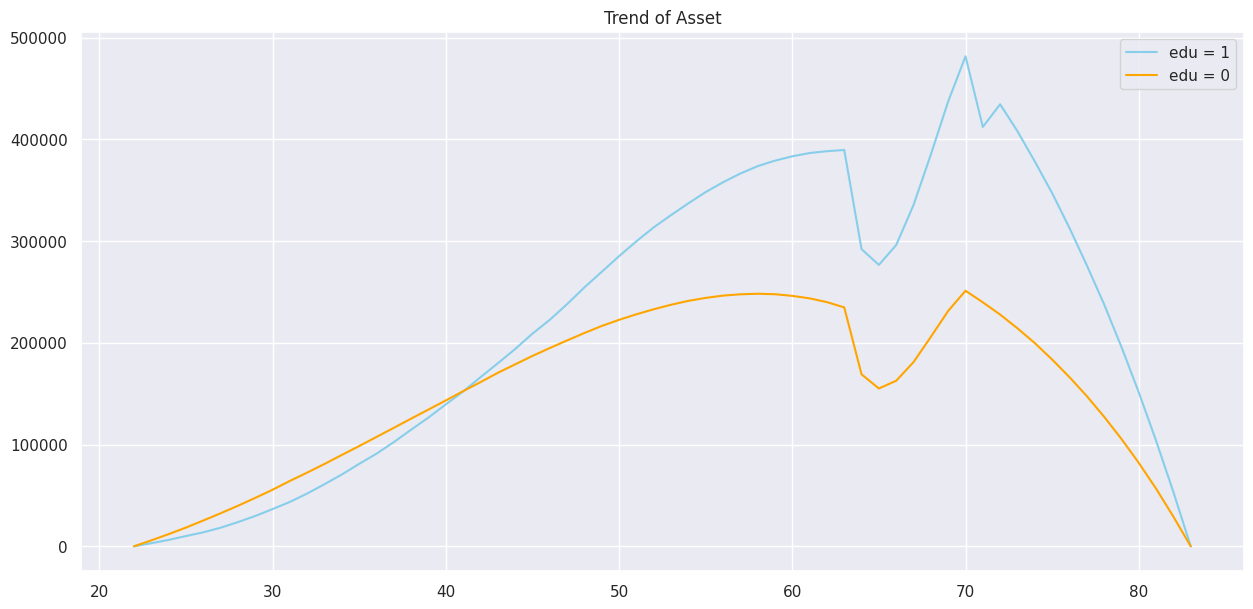

In [7]:

plot_trend(all_a, all_edu, None, 'Asset')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


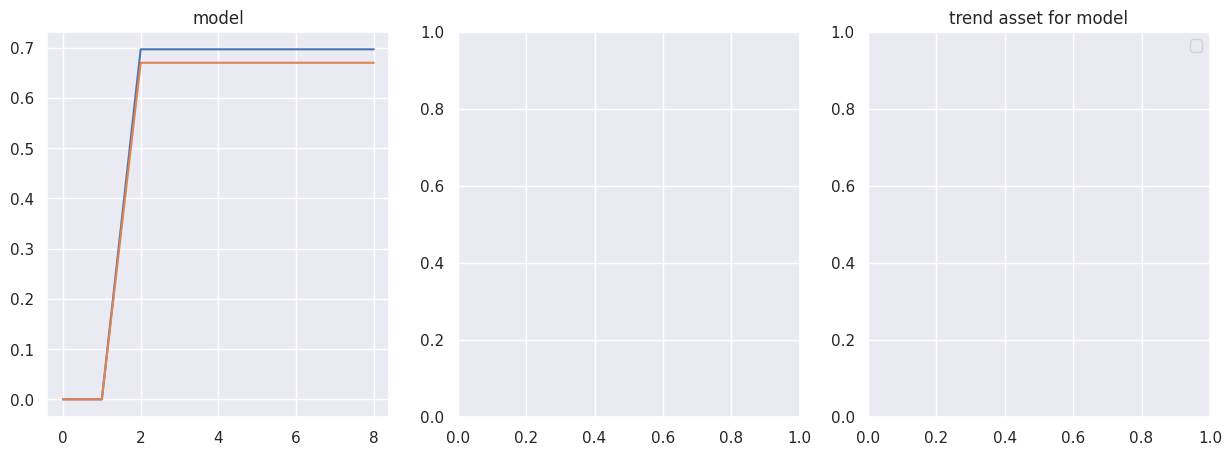

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
plt.title('trend asset for model')

ax[0].plot(  all_p[all_edu>0].mean(dim=0), label='edu=1')
ax[0].plot(  all_p[all_edu<=0].mean(dim=0), label='edu=0')
ax[0].set_title('model')


plt.legend()
plt.show()

In [9]:
all_p[all_edu>0][2]



tensor([0.0000e+00, 1.2727e-13, 3.3349e-09, 6.4787e-01, 6.4787e-01, 6.4787e-01,
        6.4787e-01, 6.4787e-01, 6.4787e-01])

In [27]:
model.work_block['year_24'].general_layer_2.weight

Parameter containing:
tensor([[-0.9453,  0.2776,  0.3481, -0.1530, -0.1236,  0.0585,  0.1428, -0.2788,
          0.2546,  0.4860],
        [-0.3729, -0.0201, -0.1459,  0.0467, -0.3626, -0.1320,  0.1272,  0.2932,
         -0.0458, -0.3649],
        [ 0.3262,  0.5352, -0.3030,  0.5026,  0.0633,  0.4774, -0.5462, -0.2473,
          0.2261, -0.9361],
        [-0.1175,  0.2213,  0.2692,  0.3213,  0.2289, -0.0161, -0.2920,  0.0604,
         -0.0548, -0.1150],
        [ 0.1188,  0.1127, -0.3353, -0.2003,  0.0161, -0.1870, -0.2415, -0.4687,
         -0.3026,  0.2890],
        [ 0.4208,  0.0536, -0.1924, -0.2465, -0.7495, -0.4807, -0.8217,  0.5467,
         -0.4970, -0.6022],
        [ 0.5822,  0.1765, -0.1787, -0.6345, -0.1301,  0.1379,  0.1623,  0.2281,
         -0.1687,  0.2426],
        [ 0.0196, -0.4056,  0.2580,  0.3050, -0.1051, -0.2719,  0.4425, -0.3116,
          0.1868,  0.3186],
        [-0.3128,  0.6491, -0.3958, -0.1524, -0.2785,  0.0113,  0.3306, -1.5191,
         -0.4582,  0.4779

In [26]:
model.work_block['year_22'].general_layer_2.weight


Parameter containing:
tensor([[-3.0227e-01,  4.6028e-01,  2.6782e-01,  1.4685e-01,  2.1635e-01,
          1.0074e-01, -2.4991e-01,  2.7842e-02,  1.2765e-01,  3.4220e-02],
        [-5.9580e-01,  6.7104e-01,  1.9897e-01, -3.7824e-01,  5.7961e-01,
          1.9287e-02,  3.7203e-01, -1.0175e+00, -6.5707e-02,  7.1573e-01],
        [ 1.5353e-01, -1.4253e-01,  5.4034e-01,  5.5079e-01, -6.3483e-01,
         -9.7970e-01,  2.6835e-01, -4.8785e-01,  2.5689e-02,  6.9173e-04],
        [ 3.0764e-01, -3.3703e-01,  9.6142e-02,  9.9754e-02, -4.2866e-01,
         -5.3300e-01, -1.8047e-01, -4.7495e-01,  2.4683e-01,  6.4665e-02],
        [-3.3923e-01,  2.1752e-01, -4.4509e-02,  2.7930e-01,  3.0348e-01,
         -1.5602e-01, -3.4835e-01, -3.1897e-01,  3.5625e-01,  4.9385e-01],
        [ 5.7503e-01, -3.3936e-01, -3.3749e-01,  2.3998e-01, -3.1851e-01,
          6.7013e-01, -3.1470e-01,  8.8939e-01, -5.0457e-01, -8.6566e-01],
        [ 5.3952e-01,  4.8768e-01,  7.8707e-03, -3.0498e-03,  1.4293e-01,
          

In [73]:
from Parameters import *
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
sns.set(color_codes=True)




def Histograms_All( data, edu, type, plots_base_dir, epoch):
    plt.figure(figsize=(15,7))
    plt.hist(data[edu > 0].view(-1), edgecolor='skyblue', bins=400, alpha= .4, label='edu = 1' )
    plt.hist(data[edu <= 0].view(-1), edgecolor='orange', bins=400, alpha= .4, label='edu = 0' )
    plt.legend()
    plt.title(f'Histogram of all {type}') 
    plt.savefig(f'{plots_base_dir}/epoch{epoch}/histograms/hist_{type}_all.png')
    plt.close()
    
    

def Histograms_Individual_Ages(data, edu, type, plots_base_dir, epoch):
    
    
    flag = type in ['Consumption', 'Asset']
        
    fig, ax = plt.subplots(1, 3+flag, figsize=(15,5))
    fig.suptitle('Histogram of Work Hour for ages 25, 40, and 55')
    ax[0].hist(data[edu > 0][:,25 - AGE_0].view(-1), bins=400,  edgecolor='skyblue', alpha= .4, label='edu = 1')
    ax[0].hist(data[edu <= 0][:,25 - AGE_0].view(-1), bins=400,  edgecolor='orange', alpha= .4, label='edu = 0')
    ax[0].set_title('Age 25')
    
    
    ax[1].hist(data[edu > 0][:,40 - AGE_0].view(-1), bins=400,  edgecolor='skyblue', alpha= .4, label='edu = 1')
    ax[1].hist(data[edu <= 0][:,40 - AGE_0].view(-1), bins=400,  edgecolor='orange', alpha= .4, label='edu = 0')
    ax[1].set_title('Age 40')
    
    ax[2].hist(data[edu <= 0][:,55 - AGE_0].view(-1), bins=400,  edgecolor='skyblue', alpha= .4, label='edu = 1')
    ax[2].hist(data[edu <= 0][:,55 - AGE_0].view(-1), bins=400,  edgecolor='orange', alpha= .4, label='edu = 0')
    ax[2].set_title('Age 55')
    
    
    if flag:
        ax[3].hist(data[edu <= 0][:,75 - AGE_0].view(-1), bins=400,  edgecolor='skyblue', alpha= .4, label='edu = 1')
        ax[3].hist(data[edu <= 0][:,75 - AGE_0].view(-1), bins=400,  edgecolor='orange', alpha= .4, label='edu = 0')
        ax[3].set_title('Age 75')
        
    
    plt.legend()
    plt.savefig(f'{plots_base_dir}/epoch{epoch}/histograms/hist_{type}_25_40_55.png')
    plt.close()
    
    
    
    
    
    
def plot_trend(data, edu, mask_retirement, type, plots_base_dir, epoch):
    
    plt.figure(figsize=(15,7))
    
    
    if type in ['Income', 'Work_Hour']:
        weights_edu_0 = torch.concat( [torch.ones((T_ER - AGE_0)) * len(data[edu<=0]) , mask_retirement[edu<=0].sum(dim=0)], dim = 0) 
        weights_edu_1 = torch.concat( [torch.ones((T_ER - AGE_0)) * len(data[edu>0]) , mask_retirement[edu>0].sum(dim=0)], dim = 0) 
        
        plt.plot( data[edu > 0][:,:T_LR].sum(dim=0)/weights_edu_1, color='skyblue', label='edu = 1')
        plt.plot( data[edu <= 0][:,:T_LR].sum(dim=0)/weights_edu_0, color='orange', label='edu = 0')
        
        plt.xticks(AGE_0, T_LR+1)

    elif type in ['Consumption', 'Asset']:
        plt.plot( data[edu > 0].median(dim=0), color='skyblue', label='edu = 1')
        plt.plot( data[edu <= 0].median(dim=0), color='orange', label='edu = 0')
        plt.xticks(AGE_0, AGE_0 + len(data[0])+1)
    
    plt.legend()
    plt.title(f'Trend of {type}') 
    plt.savefig(f'{plots_base_dir}/epoch{epoch}/trend/trend_{type}.png')
    plt.close()
    
    
def inverse_wage(wage, t, edu):
    
    if wage <= w_min:
        return 'w_min: not inversable'
    u = mu(edu, t)
    theta = torch.log(wage) - u
    return theta
        
        
def policy_function_plot_asset(model, edu, type, all_a, all_w,  plots_base_dir= None, epoch= None):
    
    device = 'cuda'
    
    fig, ax = plt.subplots(2, 3, figsize=(24,10))
    for i, age in enumerate([25, 40, 55]):

            
        sigma_1 = all_a[edu>0][:,age - AGE_0].std()
        sigma_0 = all_a[edu<=0][:,age - AGE_0].std()
        
        mean_1 = all_a[edu>0][:,age - AGE_0].mean()
        mean_0 = all_a[edu<=0][:,age - AGE_0].mean()
        
        w_q1_1 = all_w[edu>0][:,age - AGE_0].quantile(.25).to(device)
        t_q1_1 = inverse_wage(w_q1_1, age, 1)
        w_q1_0 = all_w[edu<=0][:,age - AGE_0].quantile(.25).to(device)
        t_q1_0 = inverse_wage(w_q1_0, age, 0)
        
        w_q2_1 = all_w[edu>0][:,age - AGE_0].quantile(.5).to(device)
        t_q2_1 = inverse_wage(w_q2_1, age, 1)
        w_q2_0 = all_w[edu<=0][:,age - AGE_0].quantile(.5).to(device)
        t_q2_0 = inverse_wage(w_q2_0, age, 0)
        
        w_q3_1 = all_w[edu>0][:,age - AGE_0].quantile(.75).to(device)
        t_q3_1 = inverse_wage(w_q3_1, age, 1)
        w_q3_0 = all_w[edu<=0][:,age - AGE_0].quantile(.75).to(device)
        t_q3_0 = inverse_wage(w_q3_0, age, 0)
        
        
        
        
        
        y = (torch.ones((1000, age - AGE_0)) * 50000).to(device)
        
        generated_a_1 = torch.arange(mean_1 - 2*sigma_1, mean_1 + 2 * sigma_1, 4 * sigma_1 /1000 ).to(device)[:1000]
        generated_a_0 = torch.arange(mean_0 - 2 * sigma_0, mean_0 + 2 * sigma_0, 4 * sigma_0 /1000 ).to(device)[:1000]
        
        
        if age <= T_LR:
            block = model.work_block[f'year_{age}']
        else:
            block = model.RetirementYearBlock
        
        
        h1_1, x1_1 = block(t_q1_1 * torch.ones((1000,1)).to(device), torch.ones((1000,1)).to(device), generated_a_1.unsqueeze(1), y )
        h2_1, x2_1 = block(t_q2_1 * torch.ones((1000,1)).to(device), torch.ones((1000,1)).to(device), generated_a_1.unsqueeze(1), y )
        h3_1, x3_1 = block(t_q3_1 * torch.ones((1000,1)).to(device), torch.ones((1000,1)).to(device), generated_a_1.unsqueeze(1), y )
        
        
        
        h1_0, x1_0 = block(t_q1_0 * torch.ones((1000,1)).to(device), torch.zeros((1000,1)).to(device), generated_a_0.unsqueeze(1), y )
        h2_0, x2_0= block(t_q2_0 * torch.ones((1000,1)).to(device),  torch.zeros((1000,1)).to(device), generated_a_0.unsqueeze(1), y )
        h3_0, x3_0 = block(t_q3_0 * torch.ones((1000,1)).to(device),  torch.zeros((1000,1)).to(device), generated_a_0.unsqueeze(1), y )
        
        
        
        
        
        if type=='workhour':
            
            curve1_1 = h1_1
            curve2_1 = h2_1 
            curve3_1 = h3_1
            
            
            curve1_0 = h1_0
            curve2_0 = h2_0
            curve3_0 = h3_0
            
            ylabel = 'work hour t'
        
            
            
            
        elif type=='Asset':
            
            y1_1 = h1_1 * w_q1_1
            y2_1 = h2_1 * w_q2_1
            y3_1 = h3_1 * w_q3_1
            
            y1_0 = h1_0 * w_q1_0
            y2_0 = h2_0 * w_q2_0
            y3_0 = h3_0 * w_q3_0
        
        
            curve1_1 = (1.0 -x1_1.squeeze())*((y1_1) - social_security_tax(y1_1) + generated_a_1)* (1+R) 
            curve2_1 = (1.0 -x2_1.squeeze())*((y2_1) - social_security_tax(y2_1) + generated_a_1)* (1+R) 
            curve3_1 = (1.0 -x3_1.squeeze())*((y3_1) - social_security_tax(y3_1) + generated_a_1)* (1+R) 
            
            
            
            curve1_0 = (1.0 -x1_0.squeeze())*((y1_0) - social_security_tax(y1_0) + generated_a_0)* (1+R) 
            curve2_0 = (1.0 -x2_0.squeeze())*((y2_0) - social_security_tax(y2_0) + generated_a_0)* (1+R) 
            curve3_0 = (1.0 -x3_0.squeeze())*((y3_0) - social_security_tax(y3_0) + generated_a_0)* (1+R) 
        
            ylabel = 'Asset t+1'

        
        
        ax[1][i].plot(generated_a_1.detach().cpu(), curve1_1.detach().cpu(), color='skyblue', label='edu = 1, q=1')
        ax[1][i].plot(generated_a_1.detach().cpu(), curve2_1.detach().cpu(), color='orange', label='edu = 1, q=2')
        ax[1][i].plot(generated_a_1.detach().cpu(), curve3_1.detach().cpu(), color='pink', label='edu = 1, q=3')
        ax[1][i].legend()
        ax[1][i].set_title(f'{age} edu= 1')
        ax[1][i].set_xlabel(f'Asset t')
        ax[1][i].set_ylabel(ylabel)
        

        ax[0][i].plot(generated_a_0.detach().cpu(), curve1_0.detach().cpu(), color='skyblue', label='edu = 0, q=1')
        ax[0][i].plot(generated_a_0.detach().cpu(), curve2_0.detach().cpu(), color='orange', label='edu = 0, q=2')
        ax[0][i].plot(generated_a_0.detach().cpu(), curve3_0.detach().cpu(), color='pink', label='edu = 0, q=3')
        ax[0][i].legend()
        ax[0][i].set_title(f'{age} edu= 0')
        ax[0][i].set_xlabel(f'Asset t')
        ax[0][i].set_ylabel(ylabel)
    
    # plt.plot(a_t_1, a_t)
    

In [ ]:

def policy_function_plot_wage(model, edu, type, all_a, all_w,  plots_base_dir, epoch, device):
    
    
    fig, ax = plt.subplots(2, 4, figsize=(20,10))
    for i, age in enumerate([25, 40, 55, 75]):
        if age <= T_LR:
            block = model.blocks_wr[f'year_{age}']
        else:
            block = model.blocks_r[f'year_{age}']
            
        sigma_1 = all_w[edu>0][:,age - AGE_0].std()
        sigma_0 = all_w[edu<=0][:,age - AGE_0].std()
        
        mean_1 = all_w[edu>0][:,age - AGE_0].mean()
        mean_0 = all_w[edu<=0][:,age - AGE_0].mean()
        
        a_q1_1 = all_a[edu>0][:,age - AGE_0].quantile(.25).to(device)
        a_q1_0 = all_a[edu<=0][:,age - AGE_0].quantile(.25).to(device)
        
        a_q2_1 = all_a[edu>0][:,age - AGE_0].quantile(.5).to(device)
        a_q2_0 = all_a[edu<=0][:,age - AGE_0].quantile(.5).to(device)
        
        a_q3_1 = all_a[edu>0][:,age - AGE_0].quantile(.75).to(device)
        a_q3_0 = all_a[edu<=0][:,age - AGE_0].quantile(.75).to(device)
        
        
        
        
        
        y = (torch.ones((1000, age - AGE_0)) * 50000).to(device)
        
        generated_w_1 = torch.arange(mean_1 - 2*sigma_1, mean_1 + 2 * sigma_1, 4 * sigma_1 /1000 ).to(device)[:1000]
        generated_w_0 = torch.arange(mean_0 - 2 * sigma_0, mean_0 + 2 * sigma_0, 4 * sigma_0 /1000 ).to(device)[:1000]
        
        
        generated_theta_0 = inverse_wage(generated_w_0)
        generated_theta_1 = inverse_wage(generated_w_1)
        
        
        
        h1_1, x1_1 = block(generated_theta_1, torch.ones((1000,1)).to(device), a_q1_1 * torch.ones((1000,1)).to(device), y )
        h2_1, x2_1 = block(generated_theta_1, torch.ones((1000,1)).to(device), a_q2_1 * torch.ones((1000,1)).to(device), y )
        h3_1, x3_1 = block(generated_theta_1, torch.ones((1000,1)).to(device), a_q3_1 * torch.ones((1000,1)).to(device), y )
        
        
        
        h1_0, x1_0 = block(generated_theta_0, torch.zeros((1000,1)).to(device), a_q1_0 * torch.ones((1000,1)).to(device), y )
        h2_0, x2_0= block(generated_theta_0,  torch.zeros((1000,1)).to(device), a_q2_0 * torch.ones((1000,1)).to(device), y )
        h3_0, x3_0 = block(generated_theta_0,  torch.zeros((1000,1)).to(device), a_q3_0 * torch.ones((1000,1)).to(device), y )
        
        
        
        
        
        if type=='workhour':
            
            curve1_1 = h1_1
            curve2_1 = h2_1 
            curve3_1 = h3_1
            
            
            curve1_0 = h1_0
            curve2_0 = h2_0
            curve3_0 = h3_0
        
            
            
            
        elif type=='asset':
            
            y1_1 = h1_1 * w_q1_1
            y2_1 = h2_1 * w_q2_1
            y3_1 = h3_1 * w_q3_1
            
            y1_0 = h1_0 * w_q1_0
            y2_0 = h2_0 * w_q2_0
            y3_0 = h3_0 * w_q3_0
        
        
            curve1_1 = (1.0 -x1_1.squeeze())*((y1_1) - social_security_tax(y1_1) + generated_a_1)* (1+R) 
            curve2_1 = (1.0 -x2_1.squeeze())*((y2_1) - social_security_tax(y2_1) + generated_a_1)* (1+R) 
            curve3_1 = (1.0 -x3_1.squeeze())*((y3_1) - social_security_tax(y3_1) + generated_a_1)* (1+R) 
            
            
            
            curve1_0 = (1.0 -x1_0.squeeze())*((y1_0) - social_security_tax(y1_0) + generated_a_0)* (1+R) 
            curve2_0 = (1.0 -x2_0.squeeze())*((y2_0) - social_security_tax(y2_0) + generated_a_0)* (1+R) 
            curve3_0 = (1.0 -x3_0.squeeze())*((y3_0) - social_security_tax(y3_0) + generated_a_0)* (1+R) 
        
        

        
        
        ax[1][i].plot(generated_a_1, curve1_1.detach().cpu(), color='skyblue', label='edu = 1, q=1')
        ax[1][i].plot(generated_a_1, curve2_1.detach().cpu(), color='orange', label='edu = 1, q=2')
        ax[1][i].plot(generated_a_1, curve3_1.detach().cpu(), color='pink', label='edu = 1, q=3')


        ax[0][i].plot(generated_a_0, curve1_0.detach().cpu(), color='skyblue', label='edu = 0, q=1')
        ax[0][i].plot(generated_a_0, curve2_0.detach().cpu(), color='orange', label='edu = 0, q=2')
        ax[0][i].plot(generated_a_0, curve3_0.detach().cpu(), color='pink', label='edu = 0, q=3')
    
    
    # plt.plot(a_t_1, a_t)
    

In [ ]:
plot_trend(all_a, all_edu, mask_retirement, type, plots_base_dir, epoch)

In [ ]:

policy_function_plot(model, all_edu, None, all_a, all_w,  None, None, device)

In [44]:
all_p

tensor([[0.0000, 0.5905, 0.5905,  ..., 0.5905, 0.5905, 0.5905],
        [0.0000, 0.5786, 0.5786,  ..., 0.5786, 0.5786, 0.5786],
        [0.0000, 0.5822, 0.5822,  ..., 0.5822, 0.5822, 0.5822],
        ...,
        [0.0000, 0.5649, 0.5649,  ..., 0.5649, 0.5649, 0.5649],
        [0.0000, 0.5774, 0.5774,  ..., 0.5774, 0.5774, 0.5774],
        [0.0000, 0.5804, 0.5804,  ..., 0.5804, 0.5804, 0.5804]])

In [ ]:

Histograms_Individual_Ages(all_a, all_edu, 'Consumption')

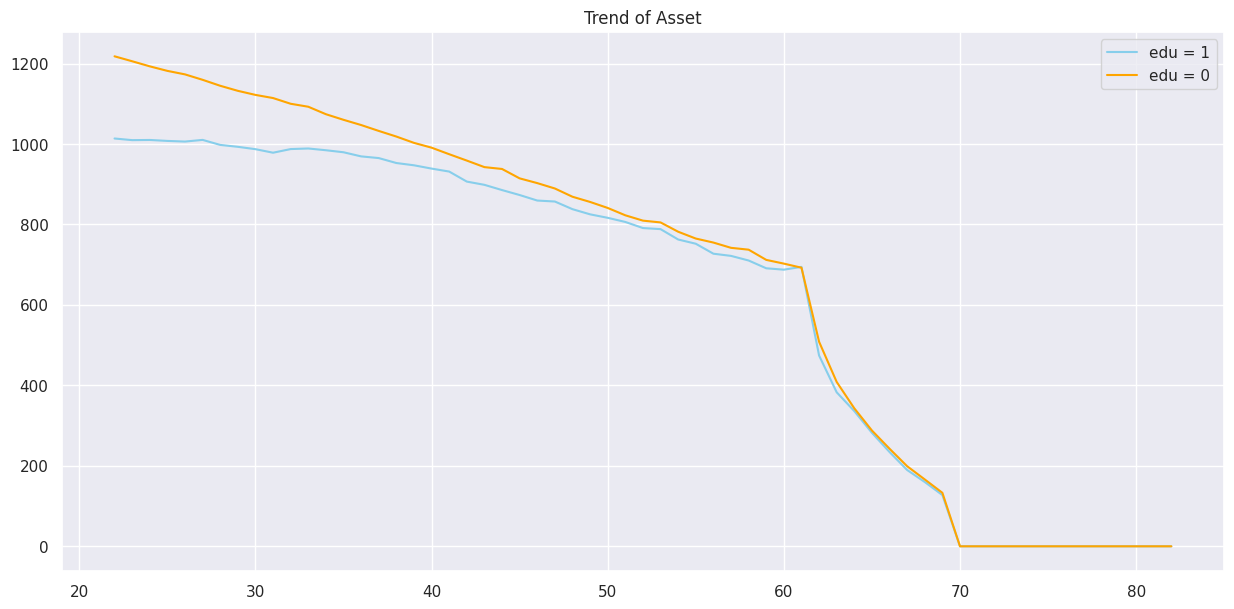

In [48]:

plot_trend(all_h, all_edu, None, 'Asset')

In [46]:
def plot_trend(data, edu, mask_retirement, type, plots_base_dir= None, epoch = None, save = False):
    
    plt.figure(figsize=(15,7))
    
    
    # if type in ['Income', 'Work_Hour']:
    #     weights_edu_0 = torch.concat( [torch.ones((T_ER - AGE_0)) * len(data[edu<=0]) , mask_retirement[edu<=0].sum(dim=0)], dim = 0) 
    #     weights_edu_1 = torch.concat( [torch.ones((T_ER - AGE_0)) * len(data[edu>0]) , mask_retirement[edu>0].sum(dim=0)], dim = 0) 
        
    #     plt.plot( data[edu > 0][:,:T_LR].sum(dim=0)/weights_edu_1, color='skyblue', label='edu = 1')
    #     plt.plot( data[edu <= 0][:,:T_LR].sum(dim=0)/weights_edu_0, color='orange', label='edu = 0')
        
    #     plt.xticks(AGE_0, T_LR+1)

    # elif type in ['Consumption', 'Asset']:
    plt.plot( range(AGE_0, len(data[0]) + AGE_0), data[edu > 0].median(dim=0).values, color='skyblue', label='edu = 1')
    plt.plot( range(AGE_0, len(data[0]) + AGE_0), data[edu <= 0].median(dim=0).values, color='orange', label='edu = 0')
        # plt.xticks())
    
    plt.legend()
    plt.title(f'Trend of {type}') 
    if save:
        plt.savefig(f'{plots_base_dir}/epoch{epoch}/trend/trend_{type}.png')
        plt.close()

In [7]:
def Histograms_Individual_Ages(data, edu, type, plots_base_dir = None, epoch = None, save = False):
    
    # print('g')
    
    flag = type in ['Consumption', 'Asset']
        
    fig, ax = plt.subplots(1, 3+flag, figsize=(20,5))
    fig.suptitle('Histogram of {} for ages 25, 40, and 55')
    ax[0].hist(data[edu > 0][:,25 - AGE_0].view(-1), bins=400,  edgecolor='skyblue', alpha= .2, label='edu = 1')
    ax[0].hist(data[edu <= 0][:,25 - AGE_0].view(-1), bins=400,  edgecolor='orange', alpha= .1, label='edu = 0')
    ax[0].set_title('Age 25')
    
    
    ax[1].hist(data[edu > 0][:,40 - AGE_0].view(-1), bins=400,  edgecolor='skyblue', alpha= .2, label='edu = 1')
    ax[1].hist(data[edu <= 0][:,40 - AGE_0].view(-1), bins=400,  edgecolor='orange', alpha= .1, label='edu = 0')
    ax[1].set_title('Age 40')
    
    ax[2].hist(data[edu > 0][:,55 - AGE_0].view(-1), bins=400,  edgecolor='skyblue', alpha= .2, label='edu = 1')
    ax[2].hist(data[edu <= 0][:,55 - AGE_0].view(-1), bins=400,  edgecolor='orange', alpha= .1, label='edu = 0')
    ax[2].set_title('Age 55')
    
    
    if flag:
        ax[3].hist(data[edu > 0][:,75 - AGE_0].view(-1), bins=400,  edgecolor='skyblue', alpha= .1, label='edu = 1')
        ax[3].hist(data[edu <= 0][:,75 - AGE_0].view(-1), bins=400,  edgecolor='orange', alpha= .1, label='edu = 0')
        ax[3].set_title('Age 75')
        
    
    plt.legend()
    if save:
        plt.savefig(f'{plots_base_dir}/epoch{epoch}/histograms/hist_{type}_25_40_55.png')
        plt.close()
        return 
    # plt.show()

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
plt.title('trend asset for model')

ax[0].plot( np.arange(AGE_0, T_D+1),  all_c[all_edu>0].mean(dim=0), label='edu=1')
ax[0].plot( np.arange(AGE_0, T_D+1),  all_c[all_edu<=0].mean(dim=0), label='edu=0')
ax[0].set_title('model')


# ax[1].plot( np.arange(AGE_0, T_D+2),  all_a_s[all_edu_s>0].mean(dim=0), label='edu=1')
# ax[1].plot( np.arange(AGE_0, T_D+2),  all_a_s[all_edu_s<=0].mean(dim=0), label='edu=0')
# ax[1].set_title('model steep')

# ax[2].plot( np.arange(AGE_0, T_D+1),  all_c_s_phi0[all_edu_s_phi0>0].mean(dim=0), label='edu=1')
# ax[2].plot( np.arange(AGE_0, T_D+1),  all_c_s_phi0[all_edu_s_phi0<=0].mean(dim=0), label='edu=0')
# ax[2].set_title('model steep and phi=0')

plt.xlim( (AGE_0, T_D+2))
plt.xticks( np.arange(AGE_0, T_D+2, 5))
# plt.title('trend asset for model')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


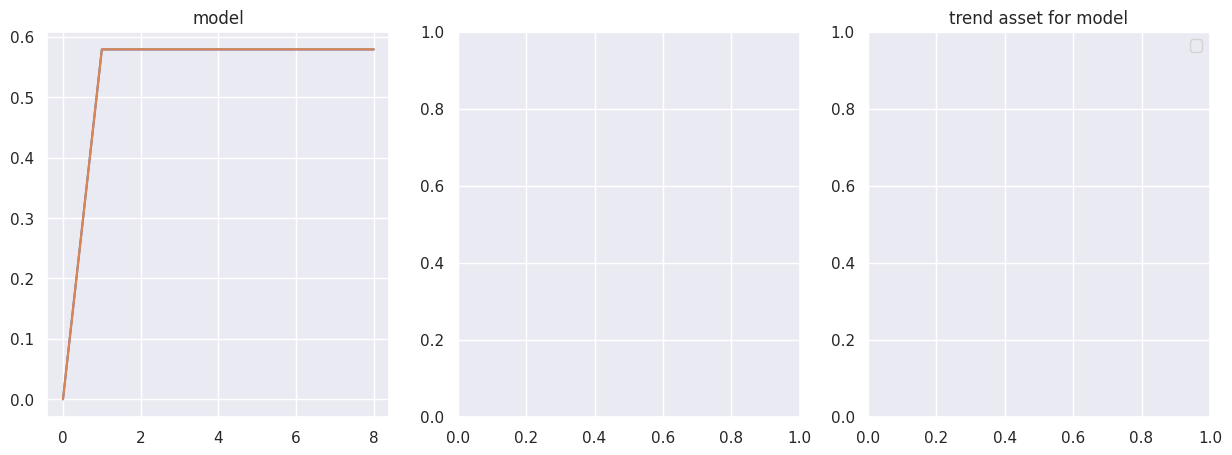

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
plt.title('trend asset for model')

ax[0].plot(  all_p[all_edu>0].mean(dim=0), label='edu=1')
ax[0].plot(  all_p[all_edu<=0].mean(dim=0), label='edu=0')
ax[0].set_title('model')


# ax[1].plot(  all_p_s[all_edu_s>0].mean(dim=0), label='edu=1')
# ax[1].plot(  all_p_s[all_edu_s<=0].mean(dim=0), label='edu=0')
# ax[1].set_title('model steep')

# ax[2].plot( all_p_s_phi0[all_edu_s_phi0>0].mean(dim=0), label='edu=1')
# ax[2].plot( all_p_s_phi0[all_edu_s_phi0<=0].mean(dim=0), label='edu=0')
# ax[2].set_title('model steep and phi=0')


# plt.xticks( np.arange(AGE_0, T_D+2, 5))/
# plt.title('trend asset for model')
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
plt.title('trend asset for model')

ax[0].plot( np.arange(AGE_0, T_D+1),  all_h[all_edu>0].mean(dim=0), label='edu=1')
ax[0].plot( np.arange(AGE_0, T_D+1),  all_h[all_edu<=0].mean(dim=0), label='edu=0')
ax[0].set_title('model')


# ax[1].plot( np.arange(AGE_0, T_D+1),  all_h_s[all_edu_s>0].mean(dim=0), label='edu=1')
# ax[1].plot( np.arange(AGE_0, T_D+1),  all_h_s[all_edu_s<=0].mean(dim=0), label='edu=0')
# ax[1].set_title('model steep')

# ax[2].plot( np.arange(AGE_0, T_D+1),  all_h_s_phi0[all_edu_s_phi0>0].mean(dim=0), label='edu=1')
# ax[2].plot( np.arange(AGE_0, T_D+1),  all_h_s_phi0[all_edu_s_phi0<=0].mean(dim=0), label='edu=0')
# ax[2].set_title('model steep and phi=0')

plt.xlim( (AGE_0, T_D+2))
plt.xticks( np.arange(AGE_0, T_D+1, 5))
# plt.title('trend asset for model')
plt.legend()
plt.show()

In [ ]:
all_p[all_edu>0][:,4]

In [ ]:
all_p_s[all_edu_s>0][:,7].max()